-32.9128707980649


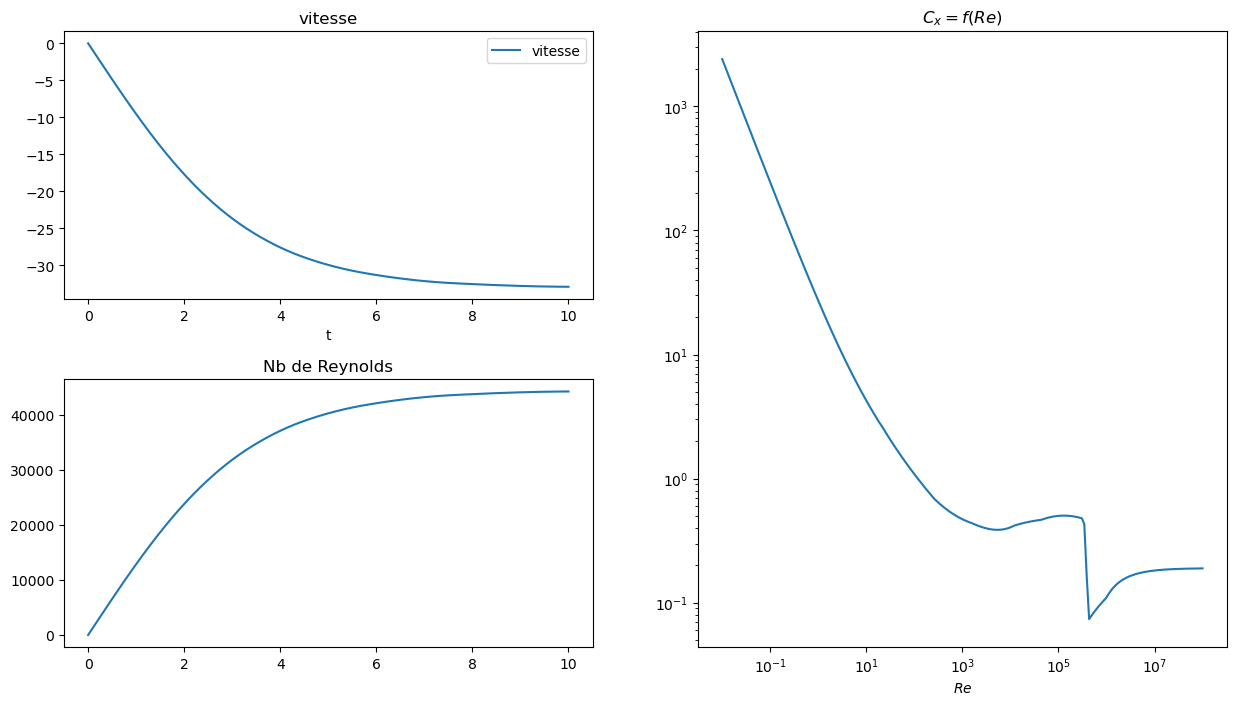

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import scipy.integrate as integrate

import importlib

scipy_utils = importlib.import_module("exo8-scipy_utils")

"""Chute libre d'une balle de golfe avec force de frottement """


def free_fall(t, v, rho, R, nu, m, g):
    """
    t : temps
    v : vitesse
    rho : masse volumique
    R rayon de la balle de golfe
    nu : viscosité dynamique
    m : masse de la balle
    retourne la dérivée de la vitesse pour une chute libre

    Ici, on prend un axe orienté vers le haut, donc une vitesse négative
    """

    return -g + force_frottement(rho, R, nu, v) / m


def force_frottement(rho, R, nu, v):
    """
    retourne la norme de la vitesse de frottement

    v : vitesse
    rho : masse volumique
    R rayon de la balle de golfe
    nu : viscosité dynamique
    """
    Re = np.abs(v * R / nu)  # Attention à la valeur absolue
    S = np.pi * R**2
    return 1 / 2 * rho * S * scipy_utils.Cx(Re) * v**2


# Programme principal
if __name__ == "__main__":
    # rayon de la balle
    R = 43e-3 / 2  # m
    # masse de la balle
    m = 45e-3  # kg
    # densité de la balle
    rho = 1.2  # kg/m3
    # viscosité dynamique de l'air
    nu = 1.6e-5
    # pesanteur
    g = 9.81
    Initial_condition = [0]
    Time_interval = [0, 10]

    sol = integrate.solve_ivp(
        free_fall,
        Time_interval,
        Initial_condition,
        method="RK23",
        vectorized=True,
        args=(rho, R, nu, m, g),
        t_eval=np.linspace(Time_interval[0], Time_interval[1], 500),
    )

    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(2, 2, hspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])

    # avec indication des points pour effectuer l'intégration
    ax1.plot(sol.t, sol.y[0, :], label="vitesse")
    ax1.legend()
    ax1.set_title("vitesse")
    ax1.set_xlabel("t")

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(sol.t, np.abs(sol.y[0, :]) * R / nu, label="Re")
    ax2.set_title("Nb de Reynolds")

    ax3 = fig.add_subplot(gs[:, 1])
    Res = np.logspace(-2, 8, 200)
    ax3.loglog(Res, scipy_utils.Cx(Res), label="Re")
    ax3.set_title("$C_x = f(Re)$")
    ax3.set_xlabel("$Re$")
    plt.savefig("chute-libre.svg")
    plt.show()

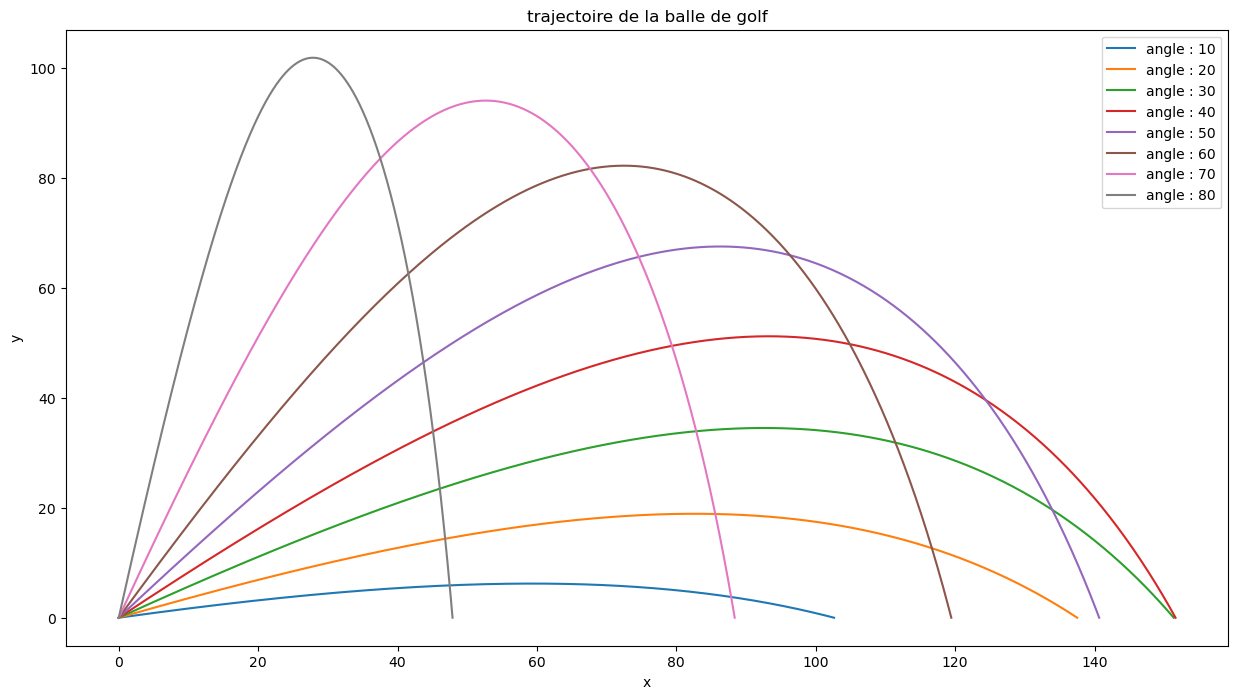

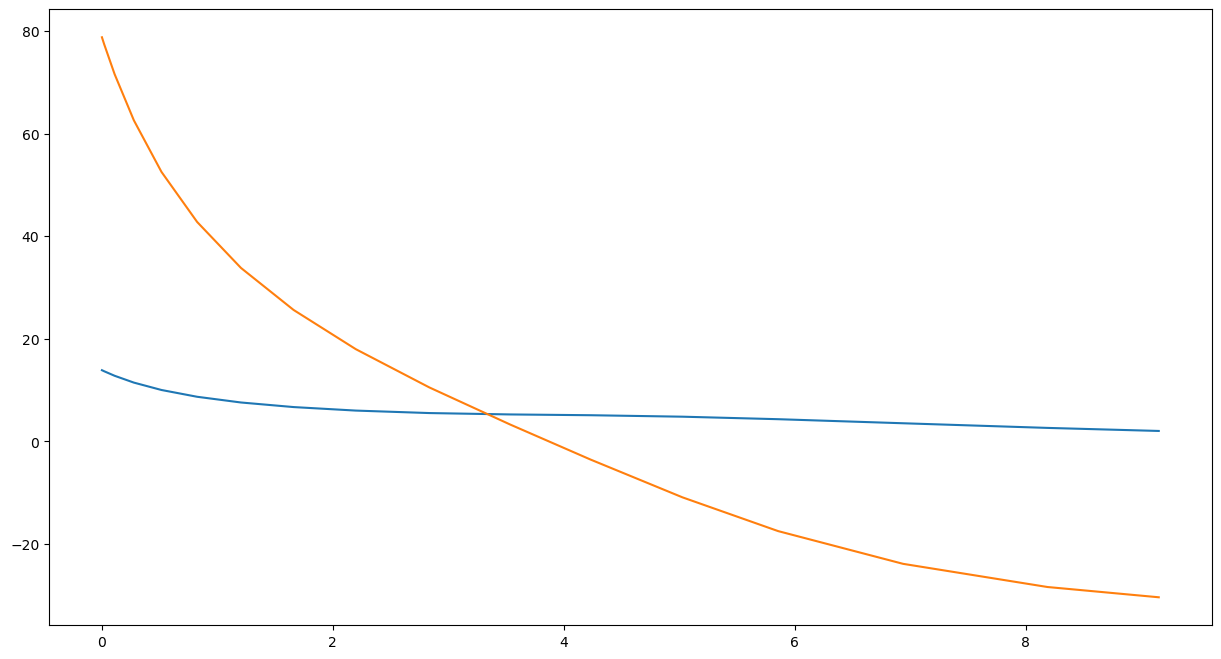

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import scipy.integrate as integrate

import importlib

scipy_utils = importlib.import_module("exo8-scipy_utils")

"""Chute libre d'une balle de golfe avec force de frottement en deux dimensions """


def free_fall(t, vec, rho, R, nu, m, g):
    """
    t : temps
    v : vitesse
    rho : masse volumique
    R rayon de la balle de golfe
    nu : viscosité dynamique
    m : masse de la balle
    retourne l'équation différentielle d'ordre deux

    Ici, on prend un axe orienté vers le haut

    Ordre des composantes : x,y,vx,vy

    la projection de l'équation différentielle donne
    m d vx/dt = - f * cos(alpha)
    m d vy/dt = -mg - f * sin (alpha)
    où alpha est l'angle entre l'horizontale et v
    cos(alpha) = vx/ ||v||
    sin(alpha) = vy/ ||v||
    """
    x, y, vx, vy = vec
    norme_v = np.sqrt(vx**2 + vy**2)
    f = force_frottement(rho, R, nu, norme_v)
    return np.array([vx, vy, -f / m * vx / norme_v, -g - f / m * vy / norme_v])


def force_frottement(rho, R, nu, v):
    """
    retourne la norme de la vitesse de frottement

    v : vitesse
    rho : masse volumique
    R rayon de la balle de golfe
    nu : viscosité dynamique
    """
    Re = np.abs(v * R / nu)
    S = np.pi * R**2
    return 1 / 2 * rho * S * scipy_utils.Cx(Re) * v**2


def stop_integration(t, vec, rho, R, nu, m, g):
    """
    fonction pour arrêter l'integration quand y s'annule
    """
    return vec[1]


# ajout des propriétés particulières à la fonction d'"events" qui s'appelle `stop_integration` pour affiner les paramètres
# on ne veut arrêter l'intégration que lors du passage de y positif vers y négatif (sinon le point t=0 est pris en compte)
stop_integration.direction = -1
# On veut arrêter l'intégration si jamais la condition est satisfaite
stop_integration.terminal = True

# Programme principal
if __name__ == "__main__":
    # rayon de la balle
    R = 43e-3 / 2  # m
    # masse de la balle
    m = 45e-3  # kg
    # densité de la balle
    rho = 1.2  # kg/m3
    # viscosité dynamique de l'air
    nu = 1.6e-5
    # pesanteur
    g = 9.81
    # vitesse initiale
    v0 = 80

    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(1, 1, hspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])

    for angle in np.arange(1, 9) * 10:
        Initial_condition = [
            0,
            0,
            v0 * np.cos(np.radians(angle)),
            v0 * np.sin(np.radians(angle)),
        ]
        Time_interval = [0, 10]

        """
        #version « question 1 »
        #si on n'a pas l'option dense_output = True, on peut tracer y(t) en fonction de x(t)
        
        sol = integrate.solve_ivp(
            free_fall,
            Time_interval,
            Initial_condition,
            method="RK23",
            vectorized=True,
            t_eval=np.linspace(Time_interval[0], Time_interval[1], 500)
            args=(rho, R, nu, m, g),
        )
        # ax1.plot(sol.y[0,:][sol.y[1,:]>=0],sol.y[1,:][sol.y[1,:]>=0],label='angle : {}'.format(angle))
        """

        # Ici, on utilise dense_output pour avoir une fonction sol.sol qui calculera la solution pour un temps t donné avec les mêmes paramètres que lors de l'appel de solve_ivp
        # On utilise également l'option 'events' pour arrêter l'intégration quand la balle à une coordonnée en y négative
        sol = integrate.solve_ivp(
            free_fall,
            Time_interval,
            Initial_condition,
            method="RK23",
            vectorized=True,
            dense_output=True,
            args=(rho, R, nu, m, g),
            events=stop_integration,
        )
        # print(sol)

        # On va tracer la fonction correspondant à l'intégration entre t=0 et le moment ou y(t) = 0 avec t>0
        ts = np.linspace(0, sol["t_events"][0][0], 500)
        # tracé avec la fonction contenue dans sol.sol, on a x,y,vx,vy
        func_values = sol.sol(ts)
        # tracé des valeurs utilisant la fonction calculée
        ax1.plot(func_values[0], func_values[1], label="angle : {}".format(angle))

    ax1.legend()
    ax1.set_title("trajectoire de la balle de golf")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    plt.savefig("chute-libre2.svg")
    plt.show()